# Map genera across multiple sample types
Install packages in new env `conda activate geo_env`

In [21]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx # this is not in a qiime2 env 
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
import re 
#import biom
import numpy as np
from matplotlib.colors import Normalize, ListedColormap

%matplotlib inline

In [2]:
workdir = '/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal'
%cd $workdir

/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal


# Get rarefied and labled ASV table 
> note run with a qiime2 environment 

In [ ]:
!qiime tools export \
    --input-path /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/bark/bark_cm15000/rarefied_table.qza \
    --output-path /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/bark/bark_cm15000/rarefied_table

!qiime tools export \
    --input-path /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/soil/soil_cm5000/rarefied_table.qza \
    --output-path /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/soil/soil_cm5000/rarefied_table


In [ ]:
# Load the BIOM table
biom_table = biom.load_table("/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/bark/bark_cm15000/rarefied_table/feature-table.biom")
df_ITS = biom_table.to_dataframe()
# rename the samples 
ITS_md = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_md.tsv', sep='\t')
column_mapping = ITS_md.set_index("id")["SAMPLE_NAME"].to_dict()
# Rename df_16S columns using the mapping
df_ITS.rename(columns=column_mapping, inplace=True)
# load the taxonomy to rename the features
# this was exported in 00_Prep_MicrobiomeDataForMetabolomics notebook 
ITS_taxonomy = pd.read_csv('/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/taxonomy/taxonomy.tsv', sep='\t')
ITS_taxonomy.set_index('Feature ID', inplace=True)
# Rename the index of df_ITS based on the 'Taxon' column of ITS_taxonomy
df_ITS.index = df_ITS.index.map(ITS_taxonomy['Taxon'])
# transpose and reset index
df_ITS = df_ITS.T
df_ITS.to_csv('bark_ASVs_rarefied_labled.tsv', sep='\t')

# Load the BIOM table
biom_table = biom.load_table("/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/soil/soil_cm5000/rarefied_table/feature-table.biom")
df_ITS = biom_table.to_dataframe()
# rename the samples 
ITS_md = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_md.tsv', sep='\t')
column_mapping = ITS_md.set_index("id")["SAMPLE_NAME"].to_dict()
# Rename df_16S columns using the mapping
df_ITS.rename(columns=column_mapping, inplace=True)
# load the taxonomy to rename the features
# this was exported in 00_Prep_MicrobiomeDataForMetabolomics notebook 
ITS_taxonomy = pd.read_csv('/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/taxonomy/taxonomy.tsv', sep='\t')
ITS_taxonomy.set_index('Feature ID', inplace=True)
# Rename the index of df_ITS based on the 'Taxon' column of ITS_taxonomy
df_ITS.index = df_ITS.index.map(ITS_taxonomy['Taxon'])
# transpose and reset index
df_ITS = df_ITS.T
df_ITS.to_csv('soil_ASVs_rarefied_labled.tsv', sep='\t')

# Get Genus of interest

In [98]:
# Read in all dataframes
df_soil = pd.read_csv('soil_ASVs_rarefied_labled.tsv', sep='\t', index_col=0)
df_bark = pd.read_csv('bark_ASVs_rarefied_labled.tsv', sep='\t', index_col=0)
df_berries = pd.read_csv('/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/berries_harvest_ASVs_rarefied_labled.tsv', sep='\t', index_col=0)
df_leavevs = pd.read_csv('/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/leaves/leaves_ASVs_rarefied_labled.tsv', sep='\t', index_col=0)

In [99]:
# Genus list and pattern to filter
genus_list = ['Hanseniaspora']
pattern = "|".join(genus_list)

# Function to filter and collapse each dataframe
def filter_and_collaps(df):
    columns_to_keep = [col for col in df.columns if re.search(pattern, col)]
    pathogen_df = df[columns_to_keep]
    collapsed_df = pathogen_df.sum(axis=1).reset_index(name='feature')
    collapsed_df = collapsed_df.rename(columns={'index': 'SAMPLE_NAME'})
    return collapsed_df

# Apply filtering and collapsing to each dataframe
collapsed_soil = filter_and_collaps(df_soil)
collapsed_bark = filter_and_collaps(df_bark)
collapsed_berries = filter_and_collaps(df_berries)
collapsed_leavevs = filter_and_collaps(df_leavevs)

In [100]:
df_md_lavaux = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv', sep='\t')
df_md_lavaux = df_md_lavaux[['SAMPLE_NAME','Latitude', 'Longitude', 'Year', 'Time_point', 'Plot_ID']]
df_md_lavaux['Time_Year'] = df_md_lavaux['Year'].astype(str) + "_" + df_md_lavaux['Time_point'].astype(str)

In [101]:
# Merge the collapsed dataframes with metadata
def merge_with_metadata(collapsed_df):
    df_map = collapsed_df.merge(df_md_lavaux, on='SAMPLE_NAME')
    return df_map

df_soil_map = merge_with_metadata(collapsed_soil)
df_bark_map = merge_with_metadata(collapsed_bark)
df_berries_map = merge_with_metadata(collapsed_berries)
df_leavevs_map = merge_with_metadata(collapsed_leavevs)

In [102]:
# Combine all dataframes into one
df_all = pd.concat([df_soil_map.assign(sample_type='soil'),
                    df_bark_map.assign(sample_type='bark'),
                    df_berries_map.assign(sample_type='berries'),
                    df_leavevs_map.assign(sample_type='leaves')])

df_all.head()

,SAMPLE_NAME,feature,Latitude,Longitude,Year,Time_point,Plot_ID,Time_Year,sample_type
0,Lavaux_2022-08-10_soil_Plot17,1.0,46.488222,6.721331,2022,Veraison,Lavaux_Plot_17,2022_Veraison,soil
1,Lavaux_2022-08-10_soil_Plot5,0.0,46.496407,6.708712,2022,Veraison,Lavaux_Plot_5,2022_Veraison,soil
2,Lavaux_2022-08-10_soil_Plot11,0.0,46.500244,6.706655,2022,Veraison,Lavaux_Plot_11,2022_Veraison,soil
3,Lavaux_2022-08-10_soil_Plot14,0.0,46.497494,6.707104,2022,Veraison,Lavaux_Plot_14,2022_Veraison,soil
4,Lavaux_2022-08-10_soil_Plot20,0.0,46.493887,6.720550,2022,Veraison,Lavaux_Plot_20,2022_Veraison,soil


In [103]:
# Filter for berries and non-berries separately
df_berries = df_all[df_all["sample_type"] == "berries"]
df_other = df_all[df_all["sample_type"] != "berries"]

# Aggregate: take the median for numerical columns and keep the first occurrence for others
df_berries_agg = df_berries.groupby(["Plot_ID", "Time_Year"], as_index=False).agg({
    "feature": "median",
    "Latitude": "median",
    "Longitude": "median",
    "SAMPLE_NAME": "first",
    "Year": "first",
    "Time_point": "first",
    "sample_type": "first"
})

# Concatenate back the non-berries data
df_all_agg = pd.concat([df_berries_agg, df_other], ignore_index=True)

# Display result
df_all_agg.tail()

,Plot_ID,Time_Year,feature,Latitude,Longitude,SAMPLE_NAME,Year,Time_point,sample_type
152,Lavaux_Plot_4,2023_Veraison,17.0,46.498857,6.708072,Lavaux_2023-08-24_leaf_Plot4_washed,2023,Veraison,leaves
153,Lavaux_Plot_15,2022_Veraison,0.0,46.506067,6.702391,Lavaux_2022-08-10_leaf_Plot15_washed,2022,Veraison,leaves
154,Lavaux_Plot_5,2022_Veraison,2.0,46.496407,6.708712,Lavaux_2022-08-10_leaf_Plot5_washed,2022,Veraison,leaves
155,Lavaux_Plot_17,2021_Veraison,0.0,46.488222,6.721331,Lavaux_2021-08-31_leaf_Plot17_washed,2021,Veraison,leaves
156,Lavaux_Plot_4,2021_Veraison,0.0,46.498857,6.708072,Lavaux_2021-08-31_leaf_Plot4_washed,2021,Veraison,leaves


In [104]:
df_all = df_all_agg.copy()

df_all['log2_feature'] = np.log2(df_all['feature'].replace(0, 1))
df_all['binary_feature'] = (df_all['feature'] > 0).astype(int)

# Convert to GeoDataFrame
gdf_samples = gpd.GeoDataFrame(df_all, geometry=gpd.points_from_xy(df_all.Longitude, df_all.Latitude), crs="EPSG:4326")
gdf_samples = gdf_samples.to_crs(epsg=3857)  

In [105]:
df_all

,Plot_ID,Time_Year,feature,Latitude,Longitude,SAMPLE_NAME,Year,Time_point,sample_type,log2_feature,binary_feature
0,Lavaux_Plot_11,2021_Harvest,2.0,46.500244,6.706655,Lavaux_2021-09-30_must_Plot11_Row6/Vine22_ID66,2021,Harvest,berries,1.000000,1
1,Lavaux_Plot_11,2022_Veraison,2.0,46.500244,6.706655,Lavaux_2022-08-10_must_Plot11,2022,Veraison,berries,1.000000,1
2,Lavaux_Plot_12,2021_Harvest,3.0,46.502628,6.704952,Lavaux_2021-09-30_must_Plot12_Row4/Vine30_ID83,2021,Harvest,berries,1.584963,1
3,Lavaux_Plot_12,2022_Harvest,0.0,46.502628,6.704952,Lavaux_2022-09-09_must_Plot12_RepA,2022,Harvest,berries,0.000000,0
4,Lavaux_Plot_12,2022_Veraison,0.0,46.502628,6.704952,Lavaux_2022-08-10_must_Plot12,2022,Veraison,berries,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
152,Lavaux_Plot_4,2023_Veraison,17.0,46.498857,6.708072,Lavaux_2023-08-24_leaf_Plot4_washed,2023,Veraison,leaves,4.087463,1
153,Lavaux_Plot_15,2022_Veraison,0.0,46.506067,6.702391,Lavaux_2022-08-10_leaf_Plot15_washed,2022,Veraison,leaves,0.000000,0
154,Lavaux_Plot_5,2022_Veraison,2.0,46.496407,6.708712,Lavaux_2022-08-10_leaf_Plot5_washed,2022,Veraison,leaves,1.000000,1
155,Lavaux_Plot_17,2021_Veraison,0.0,46.488222,6.721331,Lavaux_2021-08-31_leaf_Plot17_washed,2021,Veraison,leaves,0.000000,0


# Plot

/scratch/lfloerl/tmpdata/ipykernel_2864618/1845586454.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


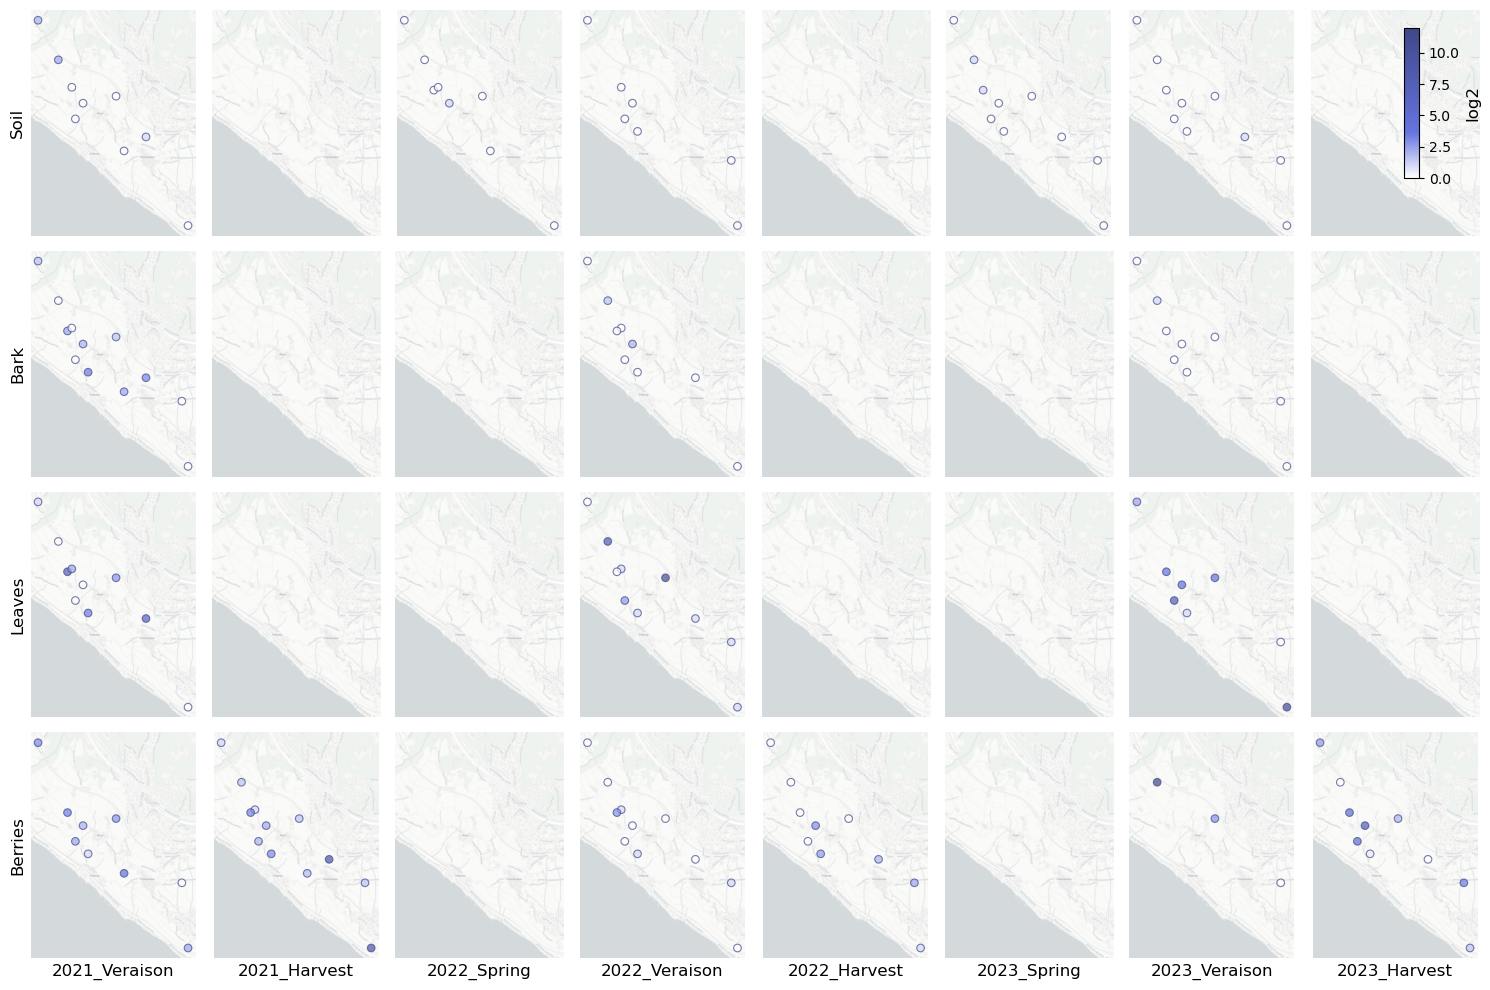

In [106]:
# Define specific order of Time_Year and sample types
time_year_order = ['2021_Veraison', '2021_Harvest', '2022_Spring', '2022_Veraison', 
                   '2022_Harvest', '2023_Spring', '2023_Veraison', '2023_Harvest']
sample_types = ['soil', 'bark', 'leaves', 'berries']

# Create a color gradient 
colors = [
    (0.0, "#FFFFFF"),  # White at 0
    (0.3, "#6674DF"),  # Blue appears earlier
    (1, "#3F4788FF")   # Green at the max
]
# Create a shifted colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_viridis_shifted", colors)


# Normalize log2 abundance values
log2_min, log2_max = gdf_samples['log2_feature'].min(), gdf_samples['log2_feature'].max()
norm = Normalize(vmin=log2_min, vmax=log2_max)

# Create a plot with 4 rows and 8 columns
fig, axes = plt.subplots(4, 8, figsize=(15, 10), sharex=True, sharey=True)

# Loop through the sample types and time points
for i, sample_type in enumerate(sample_types):
    for j, time_year in enumerate(time_year_order):
        ax = axes[i, j]
        
        # Filter data for the specific Time_Year and sample type
        gdf_time_sample = gdf_samples[(gdf_samples['Time_Year'] == time_year) & (gdf_samples['sample_type'] == sample_type)]
        
        if not gdf_time_sample.empty:  # Only plot if there's data for this combination
            gdf_time_sample.plot(ax=ax, 
                                 column='log2_feature', 
                                 cmap=custom_cmap, aspect="auto", 
                                 norm=norm, 
                                 markersize=30, 
                                 edgecolor='#3F4788FF',  # Circle around points
                                 linewidth=0.8, 
                                 legend=False, 
                                 alpha=0.7)  # Adjust transparency based on abundance
        
        # Add basemap
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, attribution=False)
        
        # Remove axes labels and ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_frame_on(False)

# Label the rows (sample types)
for i, sample_type in enumerate(sample_types):
    axes[i, 0].set_ylabel(sample_type.capitalize(), fontsize=12)

# Label the columns (Time_Year) at the top
for j, time_year in enumerate(time_year_order):
    axes[3, j].set_xlabel(time_year, fontsize=12)


# Create a new axes for the colorbar
cax = fig.add_axes([0.94, 0.817, 0.01, 0.15])  # [left, bottom, width, height]
# Create the colorbar in the new axes
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=custom_cmap), cax=cax, orientation='vertical')
cbar.set_label('log2', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Adjust the main plot to make room for the colorbar
#plt.subplots_adjust(right=0.9)

# Tight layout to adjust spacing
plt.tight_layout()
plt.show()

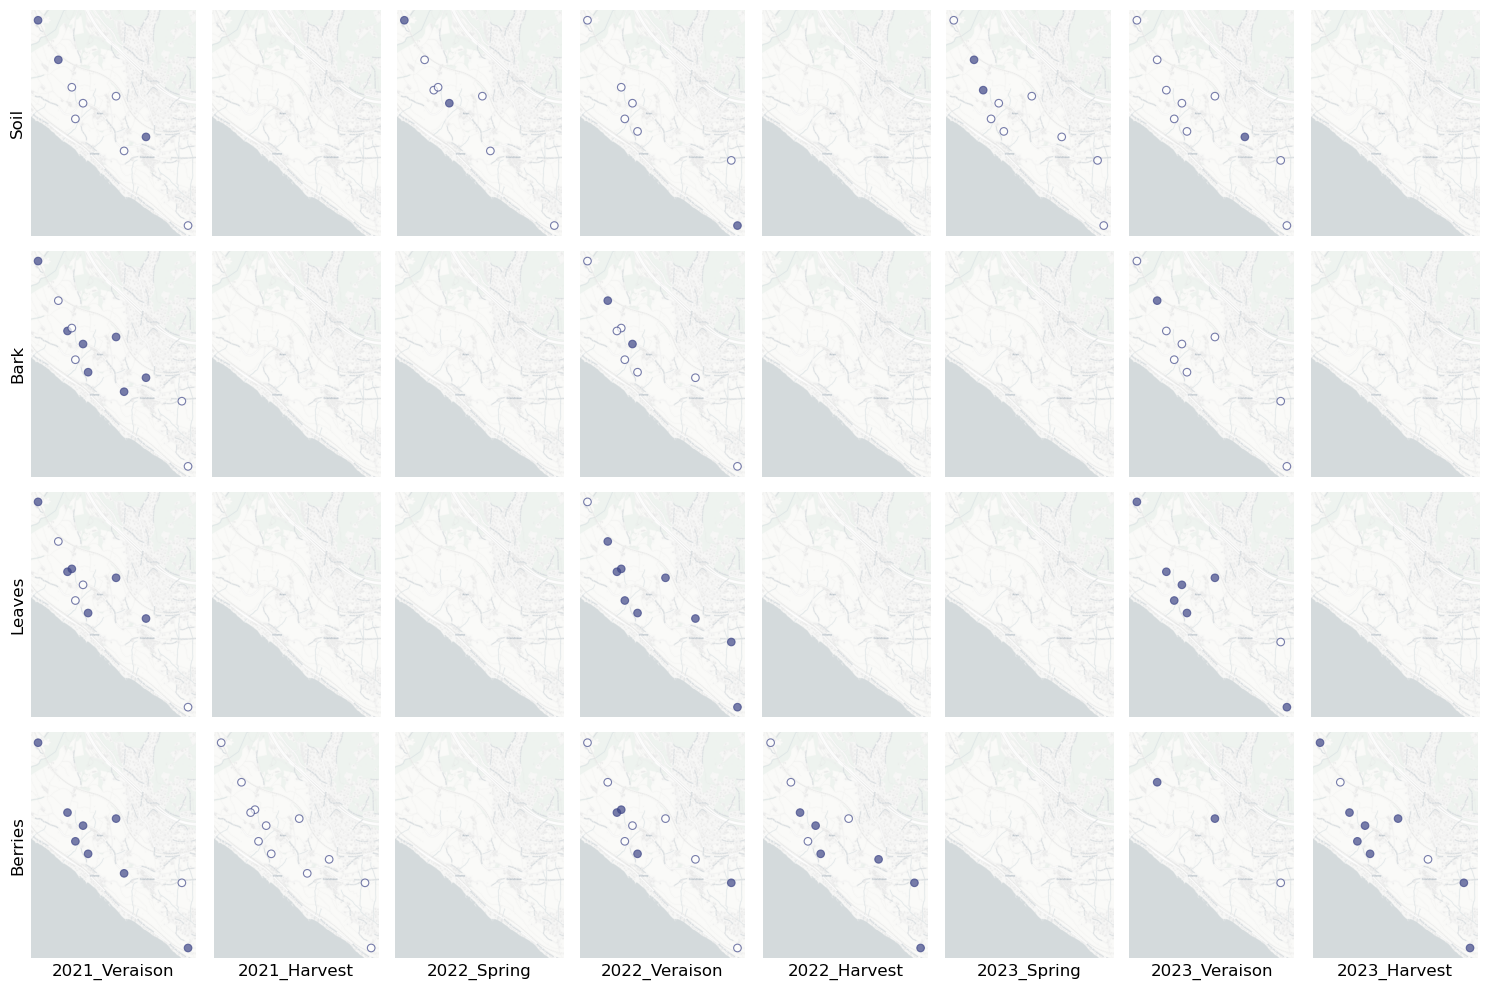

In [ ]:
# Define specific order of Time_Year and sample types
time_year_order = ['2021_Veraison', '2021_Harvest', '2022_Spring', '2022_Veraison', 
                   '2022_Harvest', '2023_Spring', '2023_Veraison', '2023_Harvest']
sample_types = ['soil', 'bark', 'leaves', 'berries']

# Create a custom colormap for binary values
binary_cmap = ListedColormap(['#FFFFFF', '#3F4788FF'])  # White for 0 and blue for 1

# Create a plot with 4 rows and 8 columns
fig, axes = plt.subplots(4, 8, figsize=(15, 10), sharex=True, sharey=True)

# Loop through the sample types and time points
for i, sample_type in enumerate(sample_types):
    for j, time_year in enumerate(time_year_order):
        ax = axes[i, j]
        
        # Filter data for the specific Time_Year and sample type
        gdf_time_sample = gdf_samples[(gdf_samples['Time_Year'] == time_year) & (gdf_samples['sample_type'] == sample_type)]
        
        if not gdf_time_sample.empty:  # Only plot if there's data for this combination
            gdf_time_sample.plot(ax=ax, 
                                 column='binary_feature', 
                                 cmap=binary_cmap,  # Use the binary colormap
                                 markersize=30, 
                                 edgecolor='#3F4788FF',  # Circle around points
                                 linewidth=0.8, 
                                 legend=False, 
                                 alpha=0.7)  # Adjust transparency based on abundance
        
        # Add basemap
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, attribution=False)
        
        # Remove axes labels and ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_frame_on(False)

# Label the rows (sample types)
for i, sample_type in enumerate(sample_types):
    axes[i, 0].set_ylabel(sample_type.capitalize(), fontsize=12)

# Label the columns (Time_Year) at the top
for j, time_year in enumerate(time_year_order):
    axes[3, j].set_xlabel(time_year, fontsize=12)

# Tight layout to adjust spacing
plt.tight_layout()
plt.show()